## Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.svm import SVC

In [2]:
# Define dataframe path
df_path = "../data/final_dataset.csv"

In [3]:
# load data
df = pd.read_csv(df_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df.shape[1]}")

Sample Data :            author                                        description  \
0          TuaAnon  yes, it's an lte watch with data turned on, no...   
1  DemandScary1934  how accurate is the active/total calorie track...   
2         Vinumite  fell very hard blackout drunk and lost watch. ...   
3          Damarou  pls tell me i‘m not the only one who has such ...   
4       ThorNike13  deleted apps in watch app on iphone with weird...   

    subreddit  des_word_count  
0  AppleWatch              48  
1  AppleWatch              10  
2  AppleWatch              59  
3  AppleWatch              15  
4  AppleWatch              15  

--------------------------

 Columns : ['author', 'description', 'subreddit', 'des_word_count']

--------------------------

 Size of the dataset : 5270

--------------------------

 Total number of columns : 4


In [4]:
# Drop unusefull columns
df.drop(columns =["author", "des_word_count"], inplace=True)

In [5]:
# Create label column (target column)
df["subreddit"] = df["subreddit"].map({"GalaxyWatch": 1, "AppleWatch":0})

## Functions

In [6]:
# cite: Got help form Katie Sylvia
# a function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = " ".join(stemmed_words)
    
    return stemmed_text

In [7]:
# Grid search over with pipeline estimator
def gridsearching(estimator, param_grid, model_name, transformer_name):
    
    print(f" Summary of {model_name} Model with {transformer_name} Transformer Evaluation ".center(115, "="))
    
    # Instantiate a GridSearch model
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs=5)

    # Fit the model to traning data
    gs.fit(X_train, y_train)

    # Get to know wich params were the best ones
    print(" The Best Params ".center(34, "="))
    print(gs.best_params_)
    print()

    # Get to know the best score
    print(" The Best Score ".center(34, "="))
    print(gs.best_score_)
    print()

    # Train data score
    print(" Train Score ".center(34, "="))
    print(gs.score(X_train, y_train))
    print()

    # Test data score
    print(" Test Score ".center(34, "="))
    print(gs.score(X_test, y_test))
    
    # Get predictions
    preds = gs.predict(X_test)

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap="Purples", values_format="d")

    plt.title(f"The Confusion Matrix of {model_name} with {transformer_name}");

    # Evaluate a model
    print(f" Evaluation Metrics ".center(34, "="))
    print(f"Accuracy  ---------- {accuracy_score(y_test, preds)}")
    print(f"Precision  --------- {precision_score(y_test, preds)}")
    print(f"Sensitivity  ------- {recall_score(y_test, preds)}")
    print(f"Specifity  --------- {tn/(tn + fp)}")

## Baselin Score

In [8]:
# Define X (features) and y(target)
X = df["description"]
y = df["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f"X shape ---------- {X.shape}")
print(f"y shape ---------- {y.shape}")

X shape ---------- (5270,)
y shape ---------- (5270,)


### Baseline accuracy

In [9]:
# Get the ratio of classes
y_test.value_counts(normalize=True)

0    0.534143
1    0.465857
Name: subreddit, dtype: float64

## Support Vector Machine (SVM) Model

### SVM with CountVectorizer

In [18]:
# Instantiate the pipeline with Logistic Regression and CountVectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("svc", SVC())
])

In [19]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('svc', SVC())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'svc': SVC(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [20]:
# Set pipeline params by cvec
pipe_params = [
    {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 10, 100]
    },
    {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "svc__kernel": ["poly"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.1, 1, 10, 100]
    }
]

========================= Summary of SVM Model with CountVectorizer Transformer Evaluation ========================
======== The Best Params =========
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'svc__C': 10, 'svc__kernel': 'rbf'}

========= The Best Score =========
0.8739899822368737

========== Train Score ===========
0.9855769230769231

=========== Test Score ===========
0.8801213960546282


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8801213960546282
Precision  --------- 0.8904109589041096
Sensitivity  ------- 0.8469055374592834
Specifity  --------- 0.9090909090909091


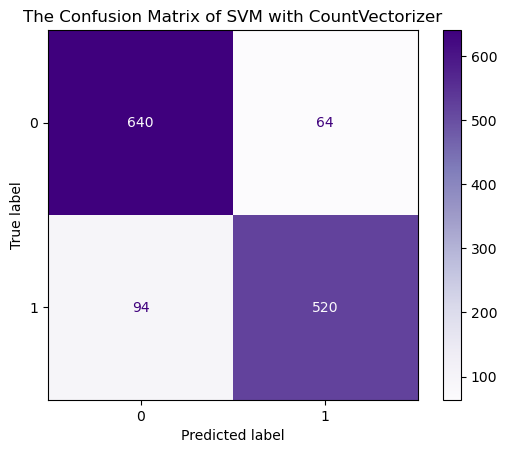

In [21]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="SVM", transformer_name="CountVectorizer")

In [14]:
# Instantiate Countvectorizer with best params 
cvec = CountVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(1,1),
                       stop_words="english", tokenizer=None)

# Fit and transform train data with countvectorizer
X_train_cvec = cvec.fit_transform(X_train)

# Transform test data with countvectorizer
X_test_cvec = cvec.transform(X_test)

# Instantiate SVM and fit the model with best params
svc_cvec = SVC(C=10, kernel="rbf")
svc_cvec.fit(X_train_cvec, y_train)

# Check the the accuracy scores again
print(f" Best SVM with CountVectorizer Train Score: {svc_cvec.score(X_train_cvec, y_train)}")
print(f" Best SVM with CountVectorizer Test Score:  {svc_cvec.score(X_test_cvec, y_test)}")

 Best SVM with CountVectorizer Train Score: 0.9855769230769231
 Best SVM with CountVectorizer Test Score:  0.8801213960546282


### SVM with TfidfVectorizer

In [10]:
# Instantiate the pipeline with Logistic Regression and CountVectorizer transformer
pipe = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("svc", SVC())
])

In [11]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'svc': SVC(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__ra

In [12]:
# Set pipeline params by cvec
pipe_params = [
    {
    "tvec__tokenizer": [None, stem_words],
    "tvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "tvec__min_df": [2, 3],
    "tvec__max_df": [.9, .95],
    "tvec__stop_words": [None, "english"],
    "tvec__ngram_range": [(1, 1), (1, 2)],
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 10, 100]
    },
    {
    "tvec__tokenizer": [None, stem_words],
    "tvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "tvec__min_df": [2, 3],
    "tvec__max_df": [.9, .95],
    "tvec__stop_words": [None, "english"],
    "tvec__ngram_range": [(1, 1), (1, 2)],
    "svc__kernel": ["poly"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.1, 1, 10, 100]
    }
]

========================= Summary of SVM Model with TfidfVectorizer Transformer Evaluation ========================
======== The Best Params =========
{'svc__C': 100, 'svc__kernel': 'rbf', 'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None, 'tvec__tokenizer': None}

========= The Best Score =========
0.8932148058058219

========== Train Score ===========
0.9992408906882592

=========== Test Score ===========
0.9013657056145675


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.9013657056145675
Precision  --------- 0.9172413793103448
Sensitivity  ------- 0.8664495114006515
Specifity  --------- 0.9318181818181818


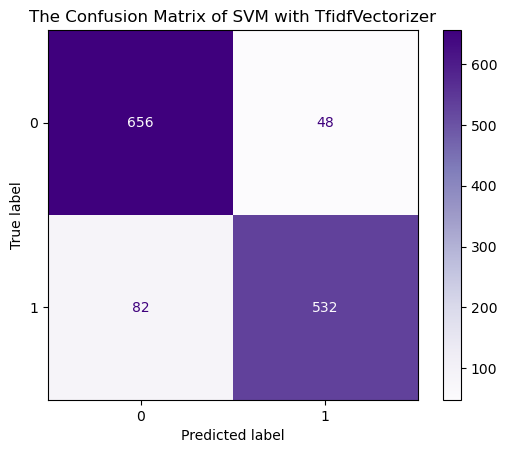

In [13]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="SVM", transformer_name="TfidfVectorizer")

In [ ]:
The Best Params =========
{'svc__C': 100, 'svc__kernel': 'rbf', 'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None, 'tvec__tokenizer': None}

In [15]:
# Instantiate Countvectorizer with best params 
tvec = TfidfVectorizer(max_df=0.9, max_features=20000, min_df=2, ngram_range=(1,2),
                       stop_words=None, tokenizer=None)

# Fit and transform train data with countvectorizer
X_train_tvec = tvec.fit_transform(X_train)

# Transform test data with countvectorizer
X_test_tvec = tvec.transform(X_test)

# Instantiate SVM and fit the model with best params
svc_tvec = SVC(C=100, kernel="rbf")
svc_tvec.fit(X_train_tvec, y_train)

# Check the the accuracy scores again
print(f" Best SVM with TfidfVectorizer Train Score: {svc_tvec.score(X_train_tvec, y_train)}")
print(f" Best SVM with TfidfVectorizer Test Score:  {svc_tvec.score(X_test_tvec, y_test)}")

 Best SVM with TfidfVectorizer Train Score: 0.9992408906882592
 Best SVM with TfidfVectorizer Test Score:  0.9013657056145675


## Save The Best Model

In [16]:
with open("../models/svc_tvec.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(svc_tvec, pickle_out)

NameError: name 'pickle' is not defined